# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [1]:
m = 1
A = 0.0100#872627258300784#0.12872631072998048#9#0.001#0.049261572870865834#0.0495#0.04922733211517334#0.04926157287086606#0.049261573076248164#0.04925#55#0.05#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [2]:
(0.12872627258300784+0.12872634887695314)/2

0.12872631072998048

Choose your grid

In [3]:
global compactified=true
global loggrid=false

global bisection=false

false

In [4]:
using Quadmath, Printf

res=m;
N=2.0^m*200.0/2.0

if compactified==true
    Xf=1.0
else
    Xf=10.0#Float128(1.0);
end

dx=Xf/N#Float128(Xf/N);
if loggrid==false
    dt=0.5*round(dx,digits=10)#0.5*dx#round(dx,digits=10);#dx
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*200.0/2.0
Tf=Nt*dt; #final time
#print(Tf)

In [5]:
print(N)

200.0

In [6]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [7]:
using Printf
include("./ScalarField.jl");
#include("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/myspline.jl");

In [8]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
#initX1=create_range(ori,Xf,dx,N)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)
#initX=create_range(ori-3.0*dx,Xf+3.0*dx,dx,N+6)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.005
the time step is 0.0025


# Initial data of m β Ψ and Ψ,x

In [9]:
using Dierckx


####

initm=zeros(L)
initbeta=zeros(L)
initpsi=zeros(L)
initderpsi=zeros(L)
#initm=Array{Float128}(undef, L)
#initbeta=Array{Float128}(undef, L)
#initpsi=Array{Float128}(undef, L)
#initderpsi=Array{Float128}(undef, L)

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#Float128(0.7)#0.01#0.7#0.01#0.7#0.7#0.7#0.01#0.7#0.3
sigma=0.3#Float128(0.3)


#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)


state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);

In [10]:
#derpsi_func(state_array[:,5]); #doesnt output the quad precision
#coef=splinethree(state_array[4:L-3,5],state_array[4:L-3,4],state_array[4:L-3,5]);

In [11]:
#evalInterval(Float128.([0.1]),initX,coef,3);

In [12]:
y0=Float128.([0.0 0.0 0.0])

state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:]);

state_array = ghost(state_array);

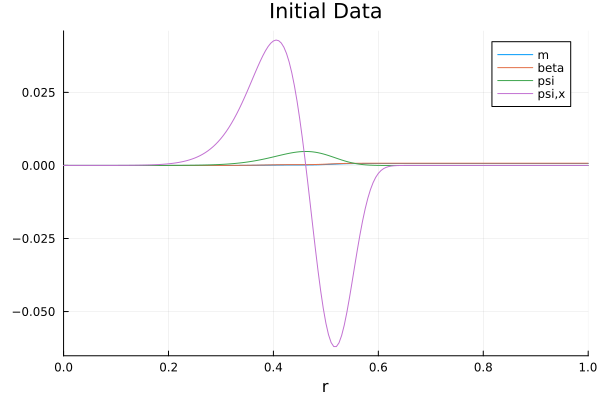

In [13]:
using Plots #showing initial data and the initial status of the horizon finder
plot((initX[4:L-3]), state_array[4:L-3,1:4], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "psi,x"],xlim=[0,1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [14]:
using CSV, Tables
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "derpsi"]

print_muninn(files, 0, state_array[:,1:5],res,"w")

In [15]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
global monitor_ratio = zeros(L);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

In [16]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

2.02015100628772


In [17]:
using Base.Threads
Threads.nthreads()

4

In [18]:
if m==1
    global dt=2e-5
elseif m==2
    global dt=1e-5
else
    global dt=1e-5/2
end

2.0e-5

 ## Time evolution

fixed grid

In [19]:
finaltime=5.0
evol_stats, T_interp = timeevolution(state_array,finaltime,run);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);



iteration 500 dt is 2.0e-5, t=0.009999999999999929 speed is 0.49501250000000013, dx/dt=249.99999999999997


iteration 1000 dt is 2.0e-5, t=0.01999999999999952 speed is 0.49501250000000024, dx/dt=249.99999999999997


iteration 1500 dt is 2.0e-5, t=0.029999999999999114 speed is 0.49501250000000063, dx/dt=249.99999999999997


iteration 2000 dt is 2.0e-5, t=0.03999999999999871 speed is 0.4950125000000018, dx/dt=249.99999999999997


iteration 2500 dt is 2.0e-5, t=0.0499999999999983 speed is 0.4950125000000037, dx/dt=249.99999999999997


iteration 3000 dt is 2.0e-5, t=0.059999999999997895 speed is 0.49501250000000724, dx/dt=249.99999999999997


iteration 3500 dt is 2.0e-5, t=0.07000000000000009 speed is 0.4950125000000135, dx/dt=249.99999999999997


iteration 4000 dt is 2.0e-5, t=0.08000000000000315 speed is 0.4950125000000242, dx/dt=249.99999999999997


iteration 4500 dt is 2.0e-5, t=0.09000000000000621 speed is 0.49501250000004166, dx/dt=249.99999999999997


iteration 5000 dt is 2.0e-5, 



iteration 39000 dt is 2.0e-5, t=0.7800000000004985 speed is 0.49501304611881203, dx/dt=249.99999999999997


iteration 39500 dt is 2.0e-5, t=0.7900000000005085 speed is 0.4950127341297278, dx/dt=249.99999999999997


iteration 40000 dt is 2.0e-5, t=0.8000000000005185 speed is 0.49501254490371793, dx/dt=249.99999999999997


iteration 40500 dt is 2.0e-5, t=0.8100000000005285 speed is 0.49501257136497073, dx/dt=249.99999999999997


iteration 41000 dt is 2.0e-5, t=0.8200000000005385 speed is 0.49501291928602503, dx/dt=249.99999999999997


iteration 41500 dt is 2.0e-5, t=0.8300000000005485 speed is 0.49501369896084013, dx/dt=249.99999999999997


iteration 42000 dt is 2.0e-5, t=0.8400000000005585 speed is 0.4950150130466684, dx/dt=249.99999999999997


iteration 42500 dt is 2.0e-5, t=0.8500000000005685 speed is 0.4950169409998313, dx/dt=249.99999999999997


iteration 43000 dt is 2.0e-5, t=0.8600000000005785 speed is 0.49501952126147974, dx/dt=249.99999999999997


iteration 43500 dt is 2.0e-5,



iteration 77500 dt is 2.0e-5, t=1.5499999999982155 speed is 0.49501250000036046, dx/dt=249.99999999999997


iteration 78000 dt is 2.0e-5, t=1.55999999999817 speed is 0.4950125000003124, dx/dt=249.99999999999997


iteration 78500 dt is 2.0e-5, t=1.5699999999981245 speed is 0.4950125000002711, dx/dt=249.99999999999997


iteration 79000 dt is 2.0e-5, t=1.579999999998079 speed is 0.49501250000023556, dx/dt=249.99999999999997


iteration 79500 dt is 2.0e-5, t=1.5899999999980334 speed is 0.495012500000205, dx/dt=249.99999999999997


iteration 80000 dt is 2.0e-5, t=1.599999999997988 speed is 0.49501250000017855, dx/dt=249.99999999999997


iteration 80500 dt is 2.0e-5, t=1.6099999999979424 speed is 0.49501250000015573, dx/dt=249.99999999999997


iteration 81000 dt is 2.0e-5, t=1.619999999997897 speed is 0.495012500000136, dx/dt=249.99999999999997


iteration 81500 dt is 2.0e-5, t=1.6299999999978514 speed is 0.49501250000011887, dx/dt=249.99999999999997


iteration 82000 dt is 2.0e-5, t=1.639



iteration 116000 dt is 2.0e-5, t=2.319999999998264 speed is 0.4950125, dx/dt=249.99999999999997


iteration 116500 dt is 2.0e-5, t=2.3299999999983294 speed is 0.49501250000000013, dx/dt=249.99999999999997


iteration 117000 dt is 2.0e-5, t=2.339999999998395 speed is 0.49501250000000013, dx/dt=249.99999999999997


iteration 117500 dt is 2.0e-5, t=2.3499999999984604 speed is 0.4950125, dx/dt=249.99999999999997


iteration 118000 dt is 2.0e-5, t=2.359999999998526 speed is 0.4950125, dx/dt=249.99999999999997


iteration 118500 dt is 2.0e-5, t=2.3699999999985915 speed is 0.4950125, dx/dt=249.99999999999997


iteration 119000 dt is 2.0e-5, t=2.379999999998657 speed is 0.4950125, dx/dt=249.99999999999997


iteration 119500 dt is 2.0e-5, t=2.3899999999987225 speed is 0.4950125, dx/dt=249.99999999999997


iteration 120000 dt is 2.0e-5, t=2.399999999998788 speed is 0.4950125, dx/dt=249.99999999999997


iteration 120500 dt is 2.0e-5, t=2.4099999999988535 speed is 0.4950125, dx/dt=249.9999999999

LoadError: InterruptException:

#### 

 ## Movie of the evolution, apparent horizon formation for 0.0492<A*<0.04925

In [48]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 710:710
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0.0, 0.1])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step710.csv" is not a valid file or doesn't exist

In [49]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8000:100:10000
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot6=functions3.Column1[4:L-3] .* 2 .* (1 .- functions3.Column5[4:L-3]) ./functions3.Column5[4:L-3];
    
    
    plot!(initX1, plot6, labels=["monitor ratio"], ylim=[-1.3, 0.6],xlim=[0.0, 0.3])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step8000.csv" is not a valid file or doesn't exist

In [50]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

In [141]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8200:5:8430
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1],xlim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1500)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/monitor_ratio8200.csv" is not a valid file or doesn't exist

Sanity check for der func

In [207]:
array=init_gaussian(originalX,0.7,0.3,0.01)
arrayloggrid=init_gaussian(initX,0.7,0.3,0.01);

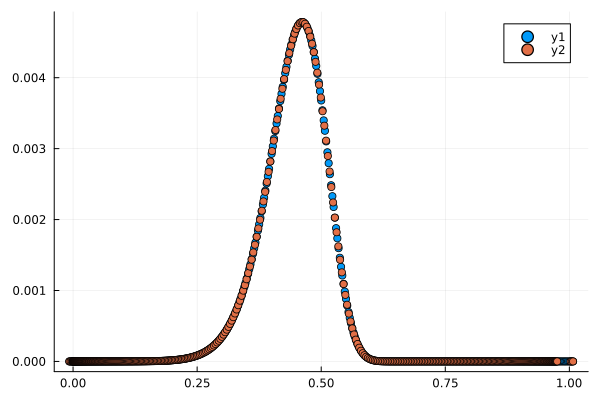

In [209]:
scatter([originalX, initX], [array, arrayloggrid])

In [210]:
aux=zeros(L)

loggrid=false
for i in 4:L-3
    aux[i]=Dertest(array,i,originalX)
end
x1=originalX
y1=aux


loggrid=true
for i in 4:L-3
    aux[i]=Dertest(arrayloggrid,i,initX)
end
x2=initX
y2=aux;

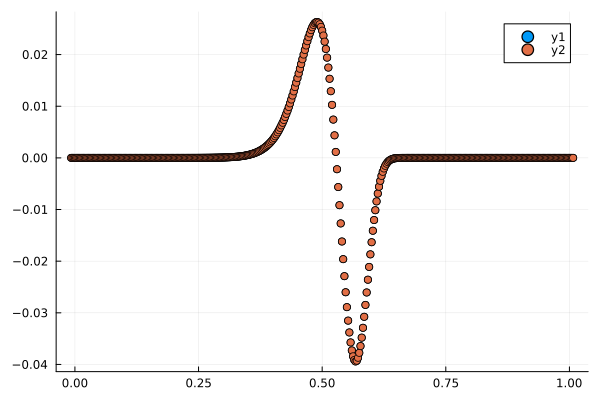

In [417]:
scatter([x1,x1],[y1,y2])